In [63]:
!pip install -U d2l
import math
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

Looking in indexes: https://mirrors.aliyun.com/pypi/simple


In [64]:
# Position_Wise Feed Forward Networks
class PositionWiseFFN(nn.Module):
    # 原论文中输入输出为512 ， 中件层为2048
    def __init__(self, ffn_num_input, fffn_num_hiddens , ffn_num_outputs , **Kwargs):
        super(PositionWiseFFN, self).__init__(**Kwargs)
        self.dense1 = nn.Linear(ffn_num_input, fffn_num_hiddens)
        self.ReLU = nn.ReLU()
        self.dense2 = nn.Linear(fffn_num_hiddens, ffn_num_outputs)
    def forward(self, X):
        return self.dense2(self.ReLU(self.dense1(X)))

In [65]:
# 改变最后一个维度
ffn = PositionWiseFFN(4 , 4 , 8)
ffn.eval()
ffn(torch.ones((2 , 3 , 4)))[0]

tensor([[-0.0580, -0.0505,  0.5580, -0.3345,  0.0970,  0.0326,  0.2097, -0.2311],
        [-0.0580, -0.0505,  0.5580, -0.3345,  0.0970,  0.0326,  0.2097, -0.2311],
        [-0.0580, -0.0505,  0.5580, -0.3345,  0.0970,  0.0326,  0.2097, -0.2311]],
       grad_fn=<SelectBackward0>)

In [66]:
# 残差链接和层归一化，每个小模块之后都要用一次
class AddNorm(nn.Module):
    # normalize_shape:对数据进行标准化，是一个二维张量（step_length , d_model）
    def __init__(self , normalize_shape , dropout , **Kwargs):
        super(AddNorm,self).__init__(**Kwargs)
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(normalize_shape)
    def forward(self, X , Y):
        # 原论文中提到的正则化方法，被加之前进行一次dropout
        # Y是上一层的输出（Multi_Head Attention的输出） ，X是残差输入
        return self.norm(self.dropout(Y)+X)

In [67]:
addnorm = AddNorm((3 , 4) , 0.5)
addnorm.eval()
# 残差快要求两个输入形状相同
addnorm(torch.ones((2 , 3 , 4)) , torch.ones(2 , 3 , 4)).shape

torch.Size([2, 3, 4])

In [68]:
# 点积注意力分数
class DotProductAttention(nn.Module):
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    # `query`: (`batch_size`, #queries, `d`)
    # `key`: (`batch_size`, #kv_pairs, `d`)
    # `value`: (`batch_size`, #kv_pairs, `dim_v`)
    # `valid_len`: either (`batch_size`, ) or (`batch_size`, xx)
    def forward(self, query, key, value, valid_len=None):
        d = query.shape[-1]
        # Set transpose_b=True to swap the last two dimensions of key
        scores = torch.bmm(query, key.transpose(1,2)) / math.sqrt(d)
        attention_weights = self.dropout(masked_softmax(scores, valid_len))
        self.attention_weights = attention_weights
        return torch.bmm(attention_weights, value)

def masked_softmax(X, valid_len):
    """Perform softmax by filtering out some elements."""
    # X: 3-D tensor, valid_len: 1-D or 2-D tensor
    if valid_len is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_len.dim() == 1:
            valid_len = torch.repeat_interleave(valid_len, repeats=shape[1],
                                                dim=0)
        else:
            valid_len = valid_len.reshape(-1)
        # Fill masked elements with a large negative, whose exp is 0
        X = d2l.sequence_mask(X.reshape(-1, shape[-1]), valid_len, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [69]:
# 对输入进行多头分割
def transpose_qkv(X, num_heads):
    """为了多注意力头的并行计算而变换形状"""
    # 例如：输入（4，16，64）——输出（4，16，4，16）
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)

    # 变为（4，4，16，16）
    X = X.permute(0, 2, 1, 3)

    # 输出合并前两个维度（16，16，16）
    return X.reshape(-1, X.shape[2], X.shape[3])

# 上面操作的逆转
def transpose_output(X, num_heads):
    """逆转transpose_qkv函数的操作"""
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)
class MultiHeadAttention(nn.Module):
    """多头注意力"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 num_heads, dropout, bias=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        # queries，keys，values的形状:
        # (batch_size，查询或者“键－值”对的个数，num_hiddens)
        # valid_lens　的形状:
        # (batch_size，)或(batch_size，查询的个数)
        # 经过变换后，输出的queries，keys，values　的形状:
        # (batch_size*num_heads，查询或者“键－值”对的个数，
        # num_hiddens/num_heads)
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)
        # 没搞懂干嘛的
        if valid_lens is not None:
            # 在轴0，将第一项（标量或者矢量）复制num_heads次，
            # 然后如此复制第二项，然后诸如此类。
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0)

        # output的形状:(batch_size*num_heads，查询的个数，
        # num_hiddens/num_heads)
        output = self.attention(queries, keys, values, valid_lens)

        # output_concat的形状:(batch_size，查询的个数，num_hiddens)
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)

In [70]:
# Encoder_block
# encoder里面有两个子层：MultiHeadAttention层 ， FFN层
# 每个层之后都要进行AddNorm
# 原论文中所有的输出维度（d_model）都是512
class EncoderBlock(nn.Module):
    # 这里的num_hiddens就是论文中的d_model
    def __init__(self , key_size , query_size , value_size , num_hiddens , 
                 norm_shape , ffn_num_input , ffn_num_hiddens , num_heads , dropout , use_bias = False , **Kwargs):
        super(EncoderBlock,self).__init__(**Kwargs)
        self.attention = MultiHeadAttention(key_size , query_size , value_size , num_hiddens , num_heads , dropout , use_bias)
        self.addnorm1 = AddNorm(norm_shape , dropout)
        self.ffn = PositionWiseFFN(ffn_num_input , ffn_num_hiddens , num_hiddens)
        self.addnorm2 = AddNorm(norm_shape , dropout) 
    def forward(self, X , valid_lens ):
        Y = self.addnorm1(X , self.attention(X , X , X , valid_lens ))
        return self.addnorm2(Y , self.ffn(Y))

In [71]:
X = torch.ones((2 , 100 , 24))
valid_lens = torch.tensor((3 , 2))
enoder_black = EncoderBlock(24 , 24 , 24 , 24 , (100 , 24) , 24 , 48 , 8 , 0.5)
enoder_black.eval()
enoder_black(X , valid_lens).shape

torch.Size([2, 100, 24])

In [72]:
class PositionalEncoding(nn.Module):
    """位置编码"""
    # max_len应该是输入序列的的长度
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        # 创建一个足够长的P
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1) / torch.pow(10000, torch.arange(
            0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

In [73]:
# Encoder_mldel
# 原论文中完整的encoder_moder由六个encoder_black组成
class TransformerEncoder(d2l.Encoder):
    def __init__(self , vocab_size , 
                 key_size , query_size , value_size , 
                 num_hiddens , norm_shape , 
                 ffn_num_input , ffn_num_hiddens ,
                 num_heads , num_layers , dropout , use_bias = False , **Kwargs):
        super(TransformerEncoder , self).__init__(**Kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size , num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens , dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block" + str(i),
                 EncoderBlock(key_size, query_size, value_size, num_hiddens,
                              norm_shape, ffn_num_input, ffn_num_hiddens,
                              num_heads, dropout, use_bias))
    def forward(self, X , valid_lens  , *args):
        # 原论文指出为了缩放嵌入向量的大小，对嵌入层的权重乘以根号下d_model
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attetion_weights = [None] * len(self.blks)
        for i , blk in enumerate(self.blks):
            X = blk(X , valid_lens)
            self.attetion_weights[i] = blk.attention.attention.attention_weights
        return X

In [74]:
# encoder = TransformerEncoder(
#     200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
# encoder.eval()
# encoder(torch.ones((2, 100), dtype=torch.long), valid_lens).shape

In [75]:
# Decoder_black
# 相比于encoder,decoder多了一个子层，mask_MultiHeadAttention层,一共三个子层
class DecoderBlock(nn.Module):
    def __init__(self , key_size , query_size , value_size,
                 num_hiddens , norm_shape , ffn_num_input , ffn_num_hiddens ,
                 num_heads , dropout , i , **Kwargs):
        super(DecoderBlock,self).__init__(**Kwargs)
        self.i = i
        self.attention1 = MultiHeadAttention(key_size , query_size , value_size , num_hiddens , num_heads , dropout)
        self.addnorm1 = AddNorm(norm_shape , dropout)
        self.attention2 = MultiHeadAttention(key_size , query_size , value_size , num_hiddens , num_heads , dropout)
        self.addnorm2 = AddNorm(norm_shape , dropout)
        self.ffn = PositionWiseFFN(ffn_num_input , ffn_num_hiddens , num_hiddens)
        self.addnorm3 = AddNorm(norm_shape , dropout)
    def forward(self, X , state ):
        # state[0]表示encoder的输出
        # state[1]表示encoder的有效长度
        # state[2]中保存了预测的结果[self.i]表示第i个序列的结果
        enc_output , enc_valid_lens = state[0] , state[1]
        # 用于decoder推理阶段对序列的处理
        # 用于判断是否是第一次处理（没有累计的结果），将key和value都设定为X
        if state[2][self.i] is None:
            key_value = X
        # 如果之前有预测结果，则合并X和之前的预测结果，作为key和value
        else:
            key_value = torch.cat((state[2][self.i] , X) , axis = 1)
        # 将之前的累计结果保存更新，以便后续使用
        state[2][self.i] = key_value
        # 用于训练阶段
        # 训练阶段需要生成掩码
        if self.training:
            batch_size , num_steps , _= X.shape
            # 用于指定decoder阶段序列的有效长度，确保只关注当前时间之前的序列
            # 形状为（batch_size ，num_steps）
            dec_valid_lens = torch.arange(1 , num_steps+1 , device=X.device).repeat(batch_size , 1)
        # 预测阶段则不需要，因为预测的结果时一个一个出来的，只能看到之前的结果
        else:
            dec_valid_lens = None
        # 自注意力
        X2 = self.attention1(X , key_value , key_value , dec_valid_lens)
        Y = self.addnorm1(X , X2)
        # 编码器-解码器注意力
        # 原论文这里的key和value的输入来自encoder的输出，query来自上一层的输出
        # 但这里key是上一层的输出，query和value是encoder的输出
        Y2 = self.attention2(Y , enc_output , enc_output , enc_valid_lens)
        Z = self.addnorm2(Y , Y2)
        return self.addnorm3(Z , self.ffn(Z)) , state

In [76]:
decoder_block = DecoderBlock(24 , 24 , 24 , 24 , (100 , 24) , 24 , 48 , 8 , 0.5 , 0)
decoder_block.eval()
X = torch.ones((2 , 100 , 24))
state = [enoder_black(X , valid_lens) , valid_lens , [None]]
decoder_block(X , state)[0].shape

torch.Size([2, 100, 24])

In [77]:
class AttentionDecoder(d2l.Decoder):
    """The base attention-based decoder interface.

    Defined in :numref:`sec_seq2seq_attention`"""
    def __init__(self):
        super().__init__()

    @property
    def attention_weights(self):
        raise NotImplementedError

In [78]:
# Decoder_model
class TransformerDecoder(AttentionDecoder):
    def __init__(self , vocab_size , key_size , query_size , value_size,
                 num_hiddens , norm_shape , ffn_num_input , ffn_num_hiddens ,
                 num_heads , num_layers , dropout , **Kwargs):
        super(TransformerDecoder , self).__init__(**Kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size , num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens , dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block" + str(i),
                                 DecoderBlock(key_size , query_size , value_size,
                 num_hiddens , norm_shape , ffn_num_input , ffn_num_hiddens ,
                 num_heads , dropout , i))
            self.dense = nn.Linear(num_hiddens , vocab_size)
    def init_state(self, enc_outputs , enc_valid_lens , *args):
        return [enc_outputs , enc_valid_lens , [None]*self.num_layers]
    def forward(self, X , state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        # decoder有两个attention层
        self._attetion_weights = [[None] * len(self.blks)for  _ in range(2)]
        for i , blk in enumerate(self.blks):
                X , state = blk(X , state)
                self._attetion_weights[0][i] = blk.attention1.attention.attention_weights
                self._attetion_weights[1][i] = blk.attention2.attention.attention_weights
        return self.dense(X) , state
    @property
    def attention_weights(self):
        return self._attetion_weights    

In [79]:
import os
def load_data_nmt(batch_size, num_steps, num_examples=600):
    """Return the iterator and the vocabularies of the translation dataset.

    Defined in :numref:`sec_utils`"""
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = d2l.Vocab(source, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = d2l.Vocab(target, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = d2l.load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab
def preprocess_nmt(text):
    """Preprocess the English-French dataset.

    Defined in :numref:`sec_utils`"""
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '

    # Replace non-breaking space with space, and convert uppercase letters to
    # lowercase ones
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    # Insert space between words and punctuation marks
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
           for i, char in enumerate(text)]
    return ''.join(out)
def read_data_nmt():
    """Load the English-French dataset.

    Defined in :numref:`sec_utils`"""
    data_dir = d2l.download_extract('fra-eng')
    with open(os.path.join(data_dir, 'fra.txt'), 'r', encoding='utf-8') as f:
        return f.read()
def tokenize_nmt(text, num_examples=None):
    """Tokenize the English-French dataset.

    Defined in :numref:`sec_utils`"""
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target
def build_array_nmt(lines, vocab, num_steps):
    """Transform text sequences of machine translation into minibatches.

    Defined in :numref:`sec_utils`"""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = d2l.tensor([truncate_pad(
        l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = d2l.reduce_sum(
        d2l.astype(array != vocab['<pad>'], d2l.int32), 1)
    return array, valid_len
def truncate_pad(line, num_steps, padding_token):
    """Truncate or pad sequences.

    Defined in :numref:`sec_utils`"""
    if len(line) > num_steps:
        return line[:num_steps]  # Truncate
    return line + [padding_token] * (num_steps - len(line))  # Pad

In [80]:
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """Train a model for sequence to sequence.

    Defined in :numref:`sec_utils`"""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])
    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                               device=device).reshape(-1, 1)
            dec_input = d2l.concat([bos, Y[:, :-1]], 1)  # Teacher forcing
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()  # Make the loss scalar for `backward`
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
          f'tokens/sec on {str(device)}')
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """The softmax cross-entropy loss with masks.

    Defined in :numref:`sec_utils`"""
    # `pred` shape: (`batch_size`, `num_steps`, `vocab_size`)
    # `label` shape: (`batch_size`, `num_steps`)
    # `valid_len` shape: (`batch_size`,)
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction='none'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
            pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss
def sequence_mask(X, valid_len, value=0):
    """Mask irrelevant entries in sequences.

    Defined in :numref:`sec_utils`"""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

In [81]:
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """Train a model for sequence to sequence.

    Defined in :numref:`sec_utils`"""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])
    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                               device=device).reshape(-1, 1)
            dec_input = d2l.concat([bos, Y[:, :-1]], 1)  # Teacher forcing
            Y_hat = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()  # Make the loss scalar for `backward`
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
          f'tokens/sec on {str(device)}')

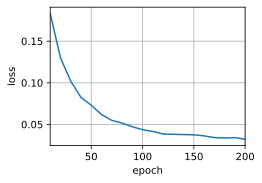

In [82]:
# 训练
num_hiddens , num_layers , dropout , batch_size , num_step = 32 , 2 , 0.1 , 64 , 10
lr , num_epochs , device =  0.005 , 200 , d2l.try_gpu()
ffn_num_input , ffn_num_hiddens , num_heads = 32 , 32 , 32
# 规范化输出维度即可
norm_shape = [32]
# src_vocab是源语言 ， tgt_vocab是目标语言
train_iter , src_vocab , tgt_vocab = load_data_nmt(batch_size , num_step)
key_size , query_size , value_size = 32 , 32 , 32

encoder = TransformerEncoder(len(src_vocab) , key_size , query_size , value_size , num_hiddens , norm_shape , ffn_num_input , ffn_num_hiddens ,num_heads , num_layers , dropout)
decoder = TransformerDecoder(len(tgt_vocab) , key_size , query_size , value_size , num_hiddens , norm_shape , ffn_num_input , ffn_num_hiddens ,num_heads , num_layers , dropout)
net = d2l.EncoderDecoder(encoder, decoder)
train_seq2seq(net , train_iter , lr , num_epochs, tgt_vocab, device)

In [84]:
# 预测
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['aller .', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(net, eng, src_vocab, tgt_vocab, num_step, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 0.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est calme .,  bleu 1.000
i'm home . => je suis chez moi .,  bleu 1.000
